In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from poisson_glm_granger import compute_granger_causality, permutation_test, filter_indirect_connections
from joblib import Parallel, delayed
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

Data contains 3 neurons, 100 trials, and 100 time steps.
0->0: Optimal lag = 1, CV score = -0.6628
1->0: Optimal lag = 1, CV score = -0.6845
2->0: Optimal lag = 1, CV score = -0.6835
0->1: Optimal lag = 1, CV score = -0.5946
1->1: Optimal lag = 1, CV score = -0.6924
2->1: Optimal lag = 18, CV score = -0.6929
0->2: Optimal lag = 2, CV score = -0.4233
1->2: Optimal lag = 1, CV score = -0.3295
2->2: Optimal lag = 20, CV score = -0.4400


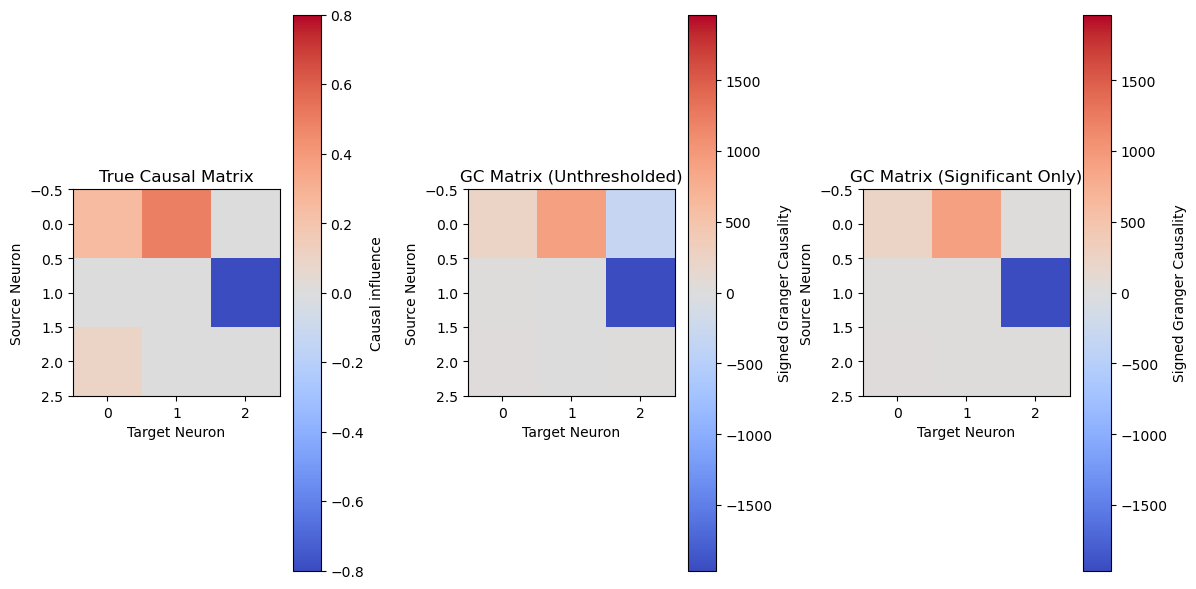

Granger Causality Matrix (Unthresholded):
[[2.39850709e+02 9.11144506e+02 3.24640385e+02]
 [1.65246376e-01 6.03627126e-03 1.96320905e+03]
 [1.58021903e+01 2.29296863e+00 3.62811869e-02]]
signed Granger Causality Matrix (Unthresholded):
[[ 2.39850709e+02  9.11144506e+02 -3.24640385e+02]
 [ 1.65246376e-01 -6.03627126e-03 -1.96320905e+03]
 [ 1.58021903e+01 -2.29296863e+00  3.62811869e-02]]

Significant Granger Causality Matrix:
[[  239.85070866   911.14450576     0.        ]
 [    0.             0.         -1963.20904546]
 [   15.80219026     0.             0.        ]]
Spearman rho=1.0, p=0.0


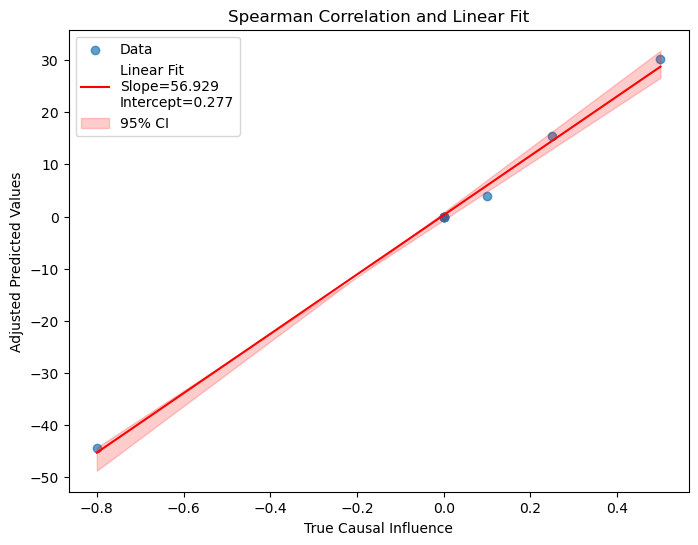

In [2]:
# Function to generate synthetic spike train data for trials
def generate_synthetic_spike_data_trials(neurons, trials, time_steps, causal_matrix, base_rate=0.01, noise_level=0.1):
    data = np.zeros((neurons, trials, time_steps))
    for trial in range(trials):
        for t in range(1, time_steps):
            for i in range(neurons):
                firing_rate = base_rate
                for j in range(neurons):
                    if causal_matrix[j, i] != 0:
                        firing_rate += causal_matrix[j, i] * data[j, trial, t - 1]
                firing_prob = max(0, min(1, firing_rate + np.random.normal(0, noise_level)))
                data[i, trial, t] = 1 if np.random.rand() < firing_prob else 0
    return data

# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, 0.0]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lag_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 3 neurons, 100 trials, and 100 time steps.
0->0: Optimal lag = 1, CV score = -0.6600
1->0: Optimal lag = 1, CV score = -0.6826
2->0: Optimal lag = 1, CV score = -0.6817
0->1: Optimal lag = 1, CV score = -0.6009
1->1: Optimal lag = 1, CV score = -0.6920
2->1: Optimal lag = 2, CV score = -0.6930
0->2: Optimal lag = 2, CV score = -0.3972
1->2: Optimal lag = 1, CV score = -0.3078
2->2: Optimal lag = 1, CV score = -0.3984


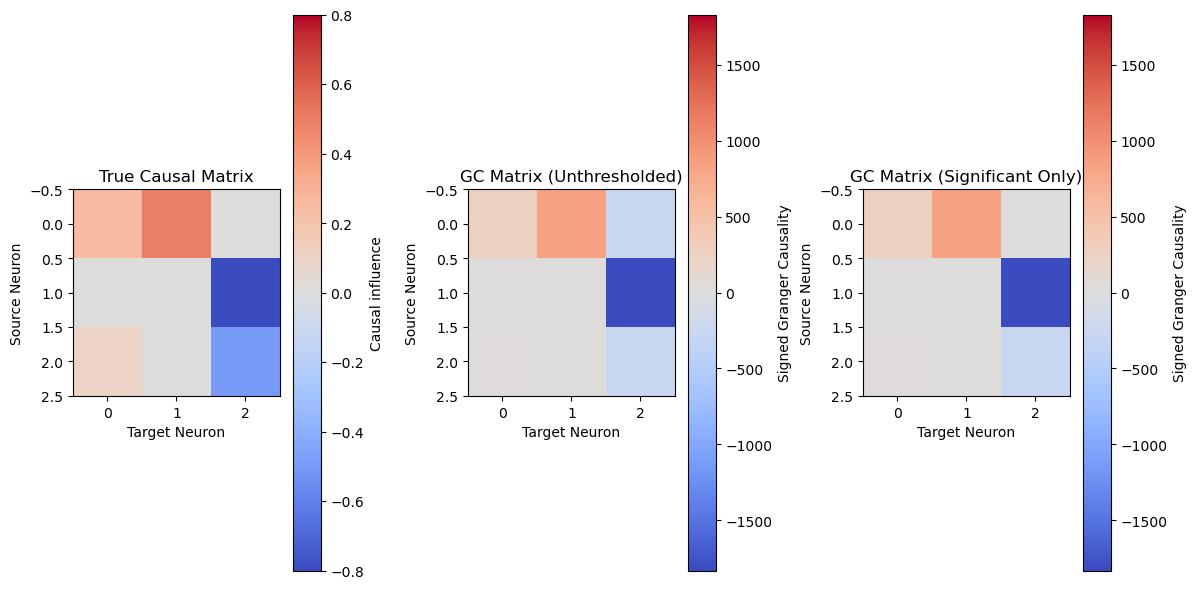

Granger Causality Matrix (Unthresholded):
[[2.53874062e+02 8.39560917e+02 2.43972727e+02]
 [6.20713349e-01 5.20767771e-04 1.83100157e+03]
 [1.87146218e+01 1.94769697e+00 2.61971246e+02]]
signed Granger Causality Matrix (Unthresholded):
[[ 2.53874062e+02  8.39560917e+02 -2.43972727e+02]
 [ 6.20713349e-01  5.20767771e-04 -1.83100157e+03]
 [ 1.87146218e+01  1.94769697e+00 -2.61971246e+02]]

Significant Granger Causality Matrix:
[[  253.87406164   839.56091709     0.        ]
 [    0.             0.         -1831.00157028]
 [   18.71462176     0.          -261.97124602]]
Spearman rho=1.0, p=0.0


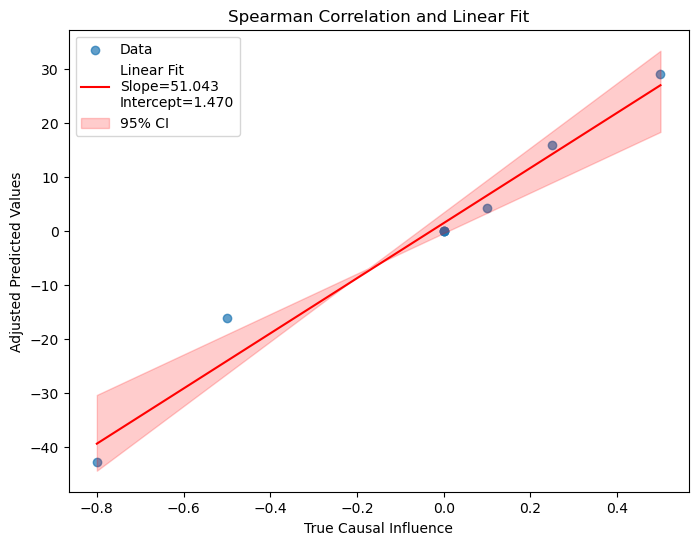

In [4]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, -0.5]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lag_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 4 neurons, 100 trials, and 100 time steps.
0->0: Optimal lag = 14, CV score = -0.6783
1->0: Optimal lag = 2, CV score = -0.6775
2->0: Optimal lag = 1, CV score = -0.6601
3->0: Optimal lag = 14, CV score = -0.6780
0->1: Optimal lag = 1, CV score = -0.6452
1->1: Optimal lag = 1, CV score = -0.6816
2->1: Optimal lag = 2, CV score = -0.6806
3->1: Optimal lag = 1, CV score = -0.6809
0->2: Optimal lag = 2, CV score = -0.6863
1->2: Optimal lag = 1, CV score = -0.6031
2->2: Optimal lag = 3, CV score = -0.6925
3->2: Optimal lag = 2, CV score = -0.6929
0->3: Optimal lag = 3, CV score = -0.6925
1->3: Optimal lag = 2, CV score = -0.6818
2->3: Optimal lag = 1, CV score = -0.6323
3->3: Optimal lag = 2, CV score = -0.6929


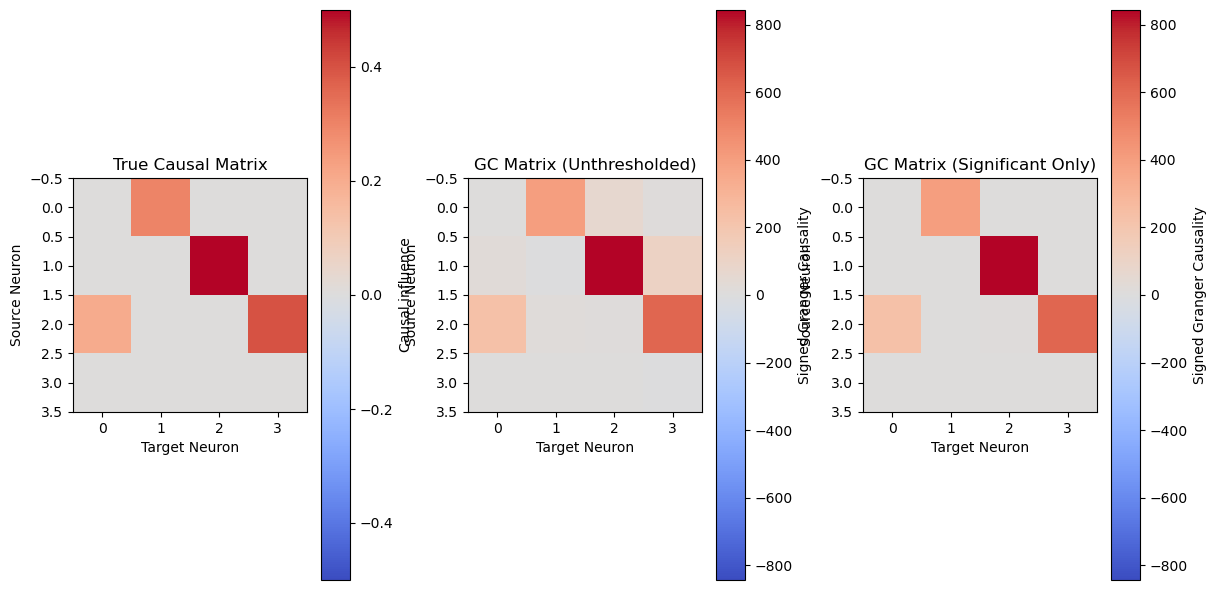

Granger Causality Matrix (Unthresholded):
[[1.60181580e-01 3.99308368e+02 6.57291271e+01 6.92977296e+00]
 [2.40018638e+01 6.63933572e-01 8.43723071e+02 1.11112696e+02]
 [2.27702435e+02 1.64103977e+01 7.06510142e+00 6.11997802e+02]
 [3.74183987e+00 2.00152196e+00 1.42293344e+00 2.11082770e+00]]
signed Granger Causality Matrix (Unthresholded):
[[ 1.60181580e-01  3.99308368e+02  6.57291271e+01  6.92977296e+00]
 [ 2.40018638e+01 -6.63933572e-01  8.43723071e+02  1.11112696e+02]
 [ 2.27702435e+02  1.64103977e+01  7.06510142e+00  6.11997802e+02]
 [ 3.74183987e+00  2.00152196e+00  1.42293344e+00 -2.11082770e+00]]

Significant Granger Causality Matrix:
[[  0.         399.30836778   0.           0.        ]
 [  0.           0.         843.72307146   0.        ]
 [227.70243489   0.           7.06510142 611.99780246]
 [  3.74183987   0.           0.           0.        ]]
Spearman rho=0.8746705343666954, p=9.292171923347173e-06


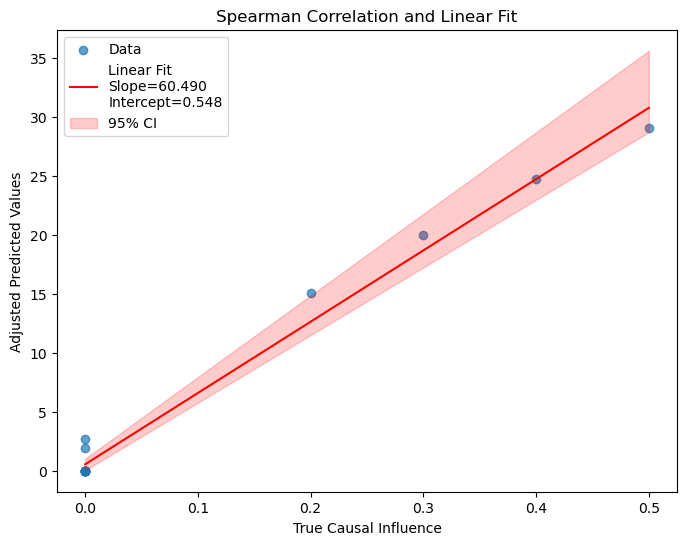

In [5]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.3, 0.0, 0.0],  # Neuron 0 causes Neuron 1
    [0.0,  0.0, 0.5, 0.0],  # Neuron 1 causes Neuron 2
    [0.2,  0.0, 0.0, 0.4],  # Neuron 2 causes Neurons 0 and 3
    [0.0,  0.0, 0.0, 0.0],  # Neuron 3 has no outgoing connections
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=4, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lag_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 6 neurons, 100 trials, and 100 time steps.
0->0: Optimal lag = 17, CV score = -0.6755
1->0: Optimal lag = 2, CV score = -0.6747
2->0: Optimal lag = 1, CV score = -0.6634
3->0: Optimal lag = 17, CV score = -0.6757
4->0: Optimal lag = 17, CV score = -0.6757
5->0: Optimal lag = 2, CV score = -0.6746
0->1: Optimal lag = 1, CV score = -0.6260
1->1: Optimal lag = 12, CV score = -0.6611
2->1: Optimal lag = 12, CV score = -0.6610
3->1: Optimal lag = 1, CV score = -0.6506
4->1: Optimal lag = 12, CV score = -0.6610
5->1: Optimal lag = 12, CV score = -0.6610
0->2: Optimal lag = 1, CV score = -0.6814
1->2: Optimal lag = 1, CV score = -0.6080
2->2: Optimal lag = 6, CV score = -0.6923
3->2: Optimal lag = 2, CV score = -0.6909
4->2: Optimal lag = 2, CV score = -0.6907
5->2: Optimal lag = 1, CV score = -0.6810
0->3: Optimal lag = 18, CV score = -0.6317
1->3: Optimal lag = 18, CV score = -0.6317
2->3: Optimal lag = 18, CV score = -0.6318
3->3: Optimal lag = 18, CV score = -0.6316
4->3: Op

/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


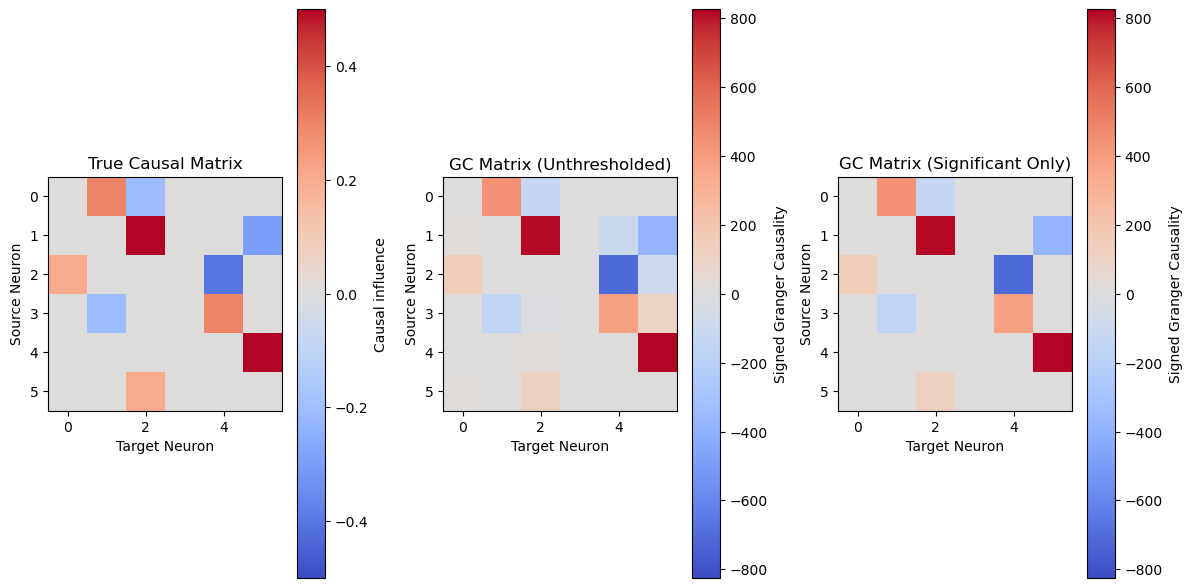

Granger Causality Matrix (Unthresholded):
[[8.87833128e-01 4.38451368e+02 1.31715070e+02 3.14755168e-02
  1.34663949e-01 3.51698920e-01]
 [1.92775656e+01 4.40039447e-01 8.14777713e+02 4.52534253e-01
  1.05940527e+02 3.74174115e+02]
 [1.44680106e+02 5.98896804e-07 4.21706779e+00 9.54477503e-03
  7.10231684e+02 8.72043429e+01]
 [2.50108991e-01 1.48396862e+02 1.92528909e+01 8.87966808e-01
  3.79342089e+02 9.96919761e+01]
 [5.72543246e-01 2.60981560e-02 2.20794283e+01 3.55356757e-02
  2.03211743e-02 8.25115847e+02]
 [1.87000017e+01 3.47115976e-01 1.13713708e+02 6.01256146e-02
  7.18060463e-01 4.58060063e+00]]
signed Granger Causality Matrix (Unthresholded):
[[ 8.87833128e-01  4.38451368e+02 -1.31715070e+02 -3.14755168e-02
  -1.34663949e-01 -3.51698920e-01]
 [ 1.92775656e+01 -4.40039447e-01  8.14777713e+02 -4.52534253e-01
  -1.05940527e+02 -3.74174115e+02]
 [ 1.44680106e+02 -5.98896804e-07  4.21706779e+00 -9.54477503e-03
  -7.10231684e+02 -8.72043429e+01]
 [ 2.50108991e-01 -1.48396862e+02 -

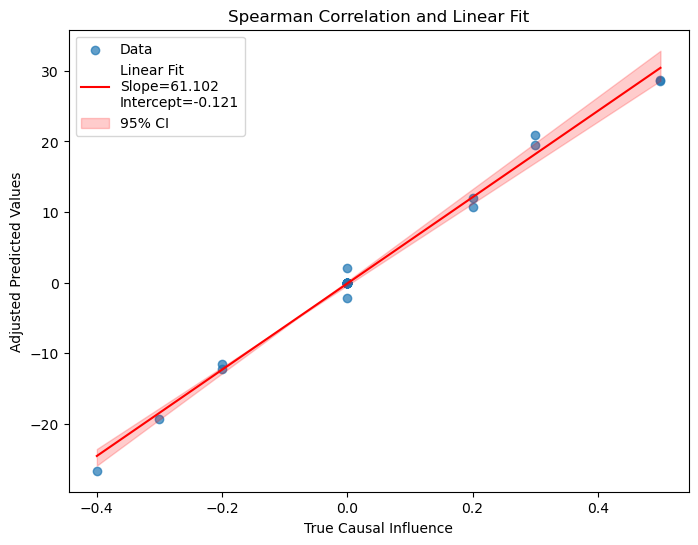

In [6]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.3, -0.2,  0.0,  0.0,  0.0],  # Neuron 0 excites Neuron 1, inhibits Neuron 2
    [0.0,  0.0,  0.5,  0.0,  0.0, -0.3],  # Neuron 1 excites Neuron 2, inhibits Neuron 5
    [0.2,  0.0,  0.0,  0.0, -0.4,  0.0],  # Neuron 2 excites Neuron 0, inhibits Neuron 4
    [0.0, -0.2,  0.0,  0.0,  0.3,  0.0],  # Neuron 3 inhibits Neuron 1, excites Neuron 4
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.5],  # Neuron 4 excites Neuron 5
    [0.0,  0.0,  0.2,  0.0,  0.0,  0.0],  # Neuron 5 excites Neuron 2
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=6, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lag_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 7 neurons, 100 trials, and 100 time steps.
0->0: Optimal lag = 2, CV score = -0.5511
1->0: Optimal lag = 1, CV score = -0.5138
2->0: Optimal lag = 2, CV score = -0.5538
3->0: Optimal lag = 1, CV score = -0.5570
4->0: Optimal lag = 3, CV score = -0.5573
5->0: Optimal lag = 3, CV score = -0.5572
6->0: Optimal lag = 3, CV score = -0.5573
0->1: Optimal lag = 1, CV score = -0.5380
1->1: Optimal lag = 2, CV score = -0.6012
2->1: Optimal lag = 1, CV score = -0.5771
3->1: Optimal lag = 1, CV score = -0.6148
4->1: Optimal lag = 1, CV score = -0.6149
5->1: Optimal lag = 2, CV score = -0.6140
6->1: Optimal lag = 1, CV score = -0.6150
0->2: Optimal lag = 1, CV score = -0.6620
1->2: Optimal lag = 1, CV score = -0.6357
2->2: Optimal lag = 2, CV score = -0.6793
3->2: Optimal lag = 2, CV score = -0.6813
4->2: Optimal lag = 2, CV score = -0.6833
5->2: Optimal lag = 1, CV score = -0.6616
6->2: Optimal lag = 20, CV score = -0.6834
0->3: Optimal lag = 2, CV score = -0.6188
1->3: Optimal lag 

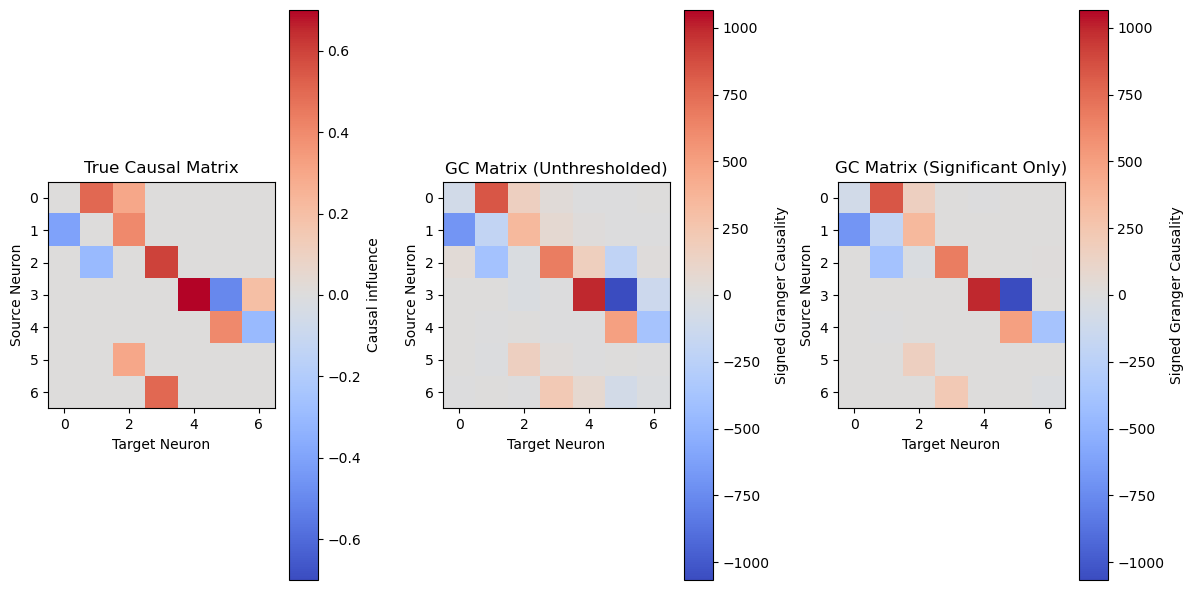

Granger Causality Matrix (Unthresholded):
[[8.65749912e+01 8.36208000e+02 1.62782765e+02 2.73047444e+01
  2.44766959e+00 4.68963095e-01 2.69818882e+00]
 [6.84709595e+02 1.98497940e+02 3.45691383e+02 5.91429091e+01
  1.47134215e+01 5.58353290e-02 3.21694625e+00]
 [3.95548730e+01 3.87701485e+02 2.58135019e+01 6.69882962e+02
  1.72163153e+02 2.16253364e+02 1.50629835e+01]
 [5.28482117e-01 2.73936571e+00 2.51715374e+01 5.13024755e-02
  9.92620021e+02 1.06723106e+03 1.28247715e+02]
 [8.90523160e-02 3.30650327e+00 3.87589099e+00 8.00346752e-05
  1.30962593e-01 4.92502569e+02 3.81607224e+02]
 [1.96140380e+00 1.46995148e+01 1.65507970e+02 2.45976143e+01
  3.51656849e-03 2.84230975e-01 3.47365032e-01]
 [1.12314530e+00 3.60283420e-01 7.62340857e-01 2.22489422e+02
  6.95764896e+01 8.18964989e+01 1.93226082e+01]]
signed Granger Causality Matrix (Unthresholded):
[[-8.65749912e+01  8.36208000e+02  1.62782765e+02  2.73047444e+01
  -2.44766959e+00 -4.68963095e-01  2.69818882e+00]
 [-6.84709595e+02 -1.

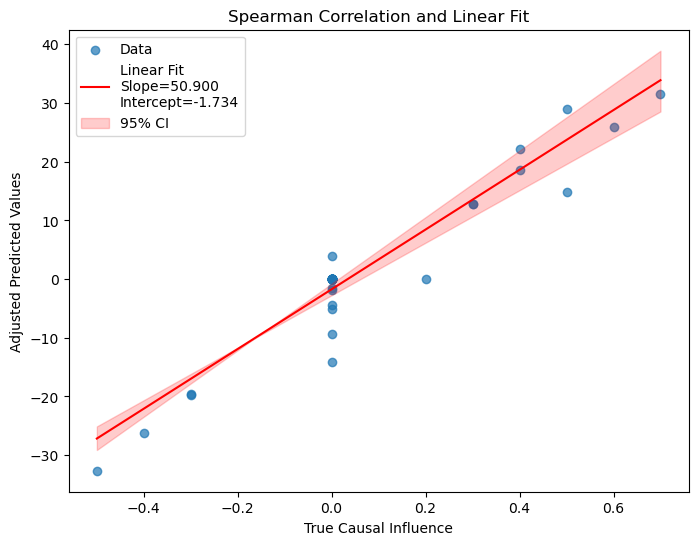

In [8]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.5,  0.3,  0.0,  0.0,  0.0,  0.0],  # Neuron 0 excites Neurons 1, 2
    [-0.4, 0.0,  0.4,  0.0,  0.0,  0.0,  0.0],  # Neuron 1 inhibits 0, excites 2
    [0.0, -0.3, 0.0,  0.6,  0.0,  0.0,  0.0],  # Neuron 2 inhibits 1, excites 3
    [0.0,  0.0,  0.0,  0.0,  0.7, -0.5,  0.2],  # Neuron 3 excites 4, inhibits 5, excites 6
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.4, -0.3],  # Neuron 4 excites 5, inhibits 6
    [0.0,  0.0,  0.3,  0.0,  0.0,  0.0,  0.0],  # Neuron 5 excites 2
    [0.0,  0.0,  0.0,  0.5,  0.0,  0.0,  0.0],  # Neuron 6 excites 3
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=7, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lag_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')
